In [180]:
import numpy as np
import os, sys
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import matplotlib.dates as mdates

sys.path.append('/Users/ajc/Core/SimDataInputs/ats-repo/ats-Aug6/tools/utils/')
sys.path.append('/Users/ajc/Core/PostProcessData/PyScript')
sys.path.append('/Users/ajc/Core/PostProcessData/PyScript/barrow')
import readdata as rd

import plot_water_table2D
sys.path.append(os.getcwd())
import SiteC_2012_2014WL 

In [2]:
time_origin = DT.datetime(2010,1,1,0,0,0)

In [4]:
import importlib as imp
imp.reload(SiteC_2012_2014WL)

data2012 = SiteC_2012_2014WL.getData_2012()

In [5]:
imp.reload(SiteC_2012_2014WL)
ObservedData2013 = dict()
data2013 = SiteC_2012_2014WL.getData_2013()

In [6]:
imp.reload(SiteC_2012_2014WL)
ObservedData2014 = dict()
data2014 = SiteC_2012_2014WL.getData_2014()

In [7]:
imp.reload(SiteC_2012_2014WL)
dataPrecip = SiteC_2012_2014WL.getDataRain()

In [8]:
#print dataPrecip.keys()
dataPrecip['Rain'] = np.concatenate((dataPrecip['rain_2012'], dataPrecip['rain_2013'], dataPrecip['rain_2014']))
dataPrecip['Time'] = np.concatenate((dataPrecip['time_2012'], dataPrecip['time_2013'], dataPrecip['time_2014']))
dataPrecip['Time'] = np.array([2010 + t/365. for t in dataPrecip['Time']])

In [9]:
ObservedData2012 = dict()
ObservedData2013 = dict()
ObservedData2014 = dict()

for key in list(data2013):#.keys():
    ObservedData2012[key] = data2012[key]
    ObservedData2013[key] = data2013[key]
    ObservedData2014[key] = data2014[key]
Z_c = 4.78591
Z_t = 4.71264

In [10]:
# correcting the elevation of the center
def OffsetData():
    for key in list(ObservedData2012):#.keys():
        if 'water_level_C40' in key:
            ObservedData2012[key + '_offset'] = np.array([d - 4.91 + Z_c for d in ObservedData2012[key]])
    for key in list(ObservedData2012):#.keys():
        if 'water_level_C39' in key:
            ObservedData2012[key + '_offset'] = np.array([d - 4.81 + Z_c for d in ObservedData2012[key]])
    for key in list(ObservedData2013):#.keys():
        if 'water_level_C39' in key:
            ObservedData2013[key + '_offset'] = np.array([d - 4.81 + Z_c for d in ObservedData2013[key]])
    for key in list(ObservedData2014):#.keys():
        if 'water_level_C39' in key:
            ObservedData2014[key + '_offset'] = np.array([d - 4.81 + Z_c for d in ObservedData2014[key]])
    #print ObservedData2012['water_level_C40_offset'].shape
OffsetData()

In [11]:
import re
def sorted_nicely( l ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [13]:
simulation = 'SiteC_3D_3R1C'
path = "/Users/ajc/Core/Projects/ATS-Data/OR-CONDO/simulations/barrow_icewedges/NGEE/SiteC_3D_June10/"

dir_files = os.listdir(path + simulation)
Vars = ['temperature-center', 'temperature-left-trough', 'ponded_depth-center', 'ponded_depth-lefttrough', 
        'saturation_gas-center','saturation_gas-left-trough']
Files = dict()
for var in Vars:
    
    Files_Temp = [f for f in dir_files if f.startswith(var)]
    Files[var] = sorted_nicely(Files_Temp)


In [14]:
DataSim= dict()
temp_C = []
for var in Vars:
    for files in Files[var]:
        dat = rd.ReadSingleFile(os.path.join(path+simulation,files))
        DataSim[files[:-4]] = np.array(dat['data'])
        time = [t/86400 for t in dat['time']]

DataSim['Time'] = time

In [15]:
def getTempAtdepths(location = 'center', saturation='saturation_liquid'):
    dat_temp = []
    dat_sl = []
    K = ''
    for key in sorted_nicely(list(DataSim)):#.keys()):
        if 'temperature' in key and location in key:
            K = key
            key_wt = saturation + key[key.find('-'):]
            if key_wt in list(DataSim):#.keys():
                #print len(DataSim[key])
                dat_temp.append(DataSim[key])
                dat_sl.append(DataSim[key_wt])
    
    #print len(dat_temp), len(time), len(dat_temp)*len(time)
    
    temp_depth = np.reshape(dat_temp, (-1,len(time)))
    sl_depth = np.reshape(dat_sl, (-1,len(time)))
    return [temp_depth, sl_depth]

def getWaterTableUpdate(location ='center',datum=0):
    depth = 0
    WaterTable = []
    WaterTableTime = []
    Surface_PD = []
    ThawDepth = []
    if 'center' in location:
        MicroLoc = 'center'
    elif 'trough' in location:
        MicroLoc = 'lefttrough'
    for key in sorted_nicely(list(DataSim)):#.keys()):
        if 'temperature' in key and location in key:
            wt_above_ice_table = True
            depth = key[key.rfind('-')+1:-2]
            
            T_at_depth, S_at_depth = getTempAtdepths(location,saturation='saturation_gas')
            
            for i in range(len(T_at_depth[0,:])):
                T_index = np.where(T_at_depth[:,i] > 273.15)[0]
                Surface_PD.append(DataSim['ponded_depth-%s'%MicroLoc][i])
                wt_position = -100
                
                if (Surface_PD[-1] > 0):
                    wt_position = 0
                elif len(T_index) > 0 and Surface_PD[-1] == 0:
                    for j in range(len(T_index)):
                        wt_position = j*0.02
                        if S_at_depth[j,i] == 0:
                            break
                        
                wt_position = wt_position if wt_position > 0 else 0
                
                thaw_index =  0.02 *(T_index[-1]+1) if len(T_index) > 0 else 0
                WaterTable.append(datum + Surface_PD[-1] - wt_position)
                WaterTableTime.append(DataSim['Time'][i])
                ThawDepth.append(datum - thaw_index)
            
            break
    
    return [WaterTableTime,WaterTable, ThawDepth]
            

In [16]:
WaterTableTimeCenter,WaterTableCenter,ThawDepthCenter = getWaterTableUpdate(datum=Z_c)
WaterTableTimeTrough,WaterTableTrough,ThawDepthTrough = getWaterTableUpdate('trough',datum=Z_t)

In [17]:
#DataSim =dict()
#time = [3*365*0 + t*365.25 for t in WaterTableTime]

DataSim['TimeCenter'] = [2010 + t/365. for t in WaterTableTimeCenter]
DataSim['WL_center'] = WaterTableCenter
DataSim['WL_trough'] = WaterTableTrough
DataSim['TimeTrough'] = [2010 + t/365. for t in WaterTableTimeTrough]
DataSim['TD_center'] = [t for t in ThawDepthCenter]
DataSim['TD_trough'] = [t for t in ThawDepthTrough]

Data_C = []
Data_T = []
Time_C = []
Time_T = []

for i,d in enumerate(DataSim['WL_center']):
    if d != 0:
        Data_C.append(d + Z_c*0)
        Time_C.append(DataSim['TimeCenter'][i])
for i,d in enumerate(DataSim['WL_trough']):
    if d != 0:
        Data_T.append(d + Z_t*0)
        Time_T.append(DataSim['TimeTrough'][i])

DataSim['water_level_center'] = np.array(Data_C)
DataSim['water_level_trough'] = np.array(Data_T)
DataSim['time_center'] = np.array(Time_C)
DataSim['time_trough'] = np.array(Time_T)

#plt.plot(DataSim['time_trough'],DataSim['water_level_trough'])

In [18]:
#--- Remove the assigned 100 to the missing data points

alpha1, alpha2 = 1, 0
LC39 = len(ObservedData2012['water_level_C39_offset'])
mask = np.ones(LC39, dtype=bool)

for i,d1 in enumerate(ObservedData2012['water_level_C39_offset']):
    if d1 > 10:
        mask[i] = False

ObservedData2012['water_level_C39_mask'] = ObservedData2012['water_level_C39_offset'][mask]
ObservedData2012['time_C39_mask'] = ObservedData2012['time_C39'][mask]

#-----------------------------------------------------------------


# Average the data at the two center wells
assert len(ObservedData2012['water_level_C39']) == len(ObservedData2012['water_level_C40_offset'])
data = []
index = np.where(ObservedData2012['water_level_C39_offset'] > 10)[0]

mid_value = 0.5*(ObservedData2012['water_level_C39_offset'][index[0]-1] + ObservedData2012['water_level_C39_offset'][index[-1]+1])

for d1,d2 in zip(ObservedData2012['water_level_C39_offset'], ObservedData2012['water_level_C40_offset']):
    sum = 0
    if d1 < 10:
        sum = 0.5*(d1+d2)
    else:
        sum = 0.5*(d2 + mid_value)
    data.append(sum)
#data = ObservedData2012['water_level_C40_offset']
ObservedData2012['water_level_Center_offset'] = np.array(data)#np.concatenate(data)

#print len(ObservedData2013['water_level_C39_offset']), len(ObservedData2013['water_level_C40'])

data = []
c = 0
for i in range(len(ObservedData2013['water_level_C39_offset'])):
    if i <7:
        data.append(ObservedData2013['water_level_C39_offset'][i])
    elif (i < 113):
        sum = alpha1*(ObservedData2013['water_level_C39_offset'][i] + alpha2*ObservedData2013['water_level_C40'][i-7])    
        data.append(sum)
    else:
        data.append(ObservedData2013['water_level_C39_offset'][i])


ObservedData2013['water_level_Center'] = np.array(data) #np.concatenate(data)

#--- 2014
#print len(ObservedData2014['water_level_C39']), len(ObservedData2014['water_level_C40'])
data = []
for i in range(len(ObservedData2014['water_level_C39_offset'])):
        sum = alpha1*(ObservedData2014['water_level_C39_offset'][i] + alpha2*ObservedData2014['water_level_C40'][i])    
        data.append(sum)

ObservedData2014['water_level_Center'] = np.array(data)#np.concatenate(data)

for key in list(ObservedData2012):#.keys():
    if 'time' in key:
        ObservedData2012[key + '_yr'] =  np.array([2010 + t/365.0 for t in ObservedData2012[key]])
for key in list(ObservedData2013):#.keys():
    if 'time' in key:
        ObservedData2013[key + '_yr'] =  np.array([2010 + t/365.0 for t in ObservedData2013[key]])

for key in list(ObservedData2014):#.keys():
    if 'time' in key and 'yr' not in key:
        ObservedData2014[key + '_yr'] =  np.array([2010 + t/365.0 for t in ObservedData2014[key]])




In [19]:
SimRain = rd.GetSurfVarFromVis(path+'%s/visdump_surface_data.h5'%simulation, 'surface-precipitation_rain', cellid=0)
SimSnow = rd.GetSurfVarFromVis(path+'%s/visdump_snow_data.h5'%simulation, 'snow-conductivity', cellid=0)
#print SimRain.keys()
DataSim['precipitation_rain'] = [-r*86400.*1000 for r in SimRain['surface-precipitation_rain']]
DataSim['thermal_conductivity'] = [r*86400.*1000 for r in SimSnow['snow-conductivity']]
#print DataSim['precipitation_rain']

In [149]:
def get_time_format(dat):
    Dat = []
    year = int(dat[0])
    year_start = DT.date(year,1,1)
    dateFormatted = year_start.strftime("%y")
    #year_start = format(dateFormatted)
    for i in dat:
        f = float(i)
        delta = year_start + DT.timedelta(days = int((i-year)*365) )
        #delta = format(dateFormatted) + DT.timedelta(days = int((i-year)*365) )
        Dat.append(delta)
    print (len(dat), len(Dat))
    return Dat


ObservedData2012['time_C37_yr_f'] = get_time_format(ObservedData2012['time_C37_yr'])
ObservedData2013['time_C37_yr_f'] = get_time_format(ObservedData2013['time_C37_yr'])
ObservedData2014['time_C37_yr_f'] = get_time_format(ObservedData2014['time_C37_yr'])

ObservedData2012['time_C39_yr_f'] = get_time_format(ObservedData2012['time_C39_yr'])
ObservedData2013['time_C39_yr_f'] = get_time_format(ObservedData2013['time_C39_yr'])
ObservedData2014['time_C39_yr_f'] = get_time_format(ObservedData2014['time_C39_yr'])

ObservedData2012['time_C40_yr_f'] = get_time_format(ObservedData2012['time_C40_yr'])
ObservedData2013['time_C40_yr_f'] = get_time_format(ObservedData2013['time_C40_yr'])
ObservedData2014['time_C40_yr_f'] = get_time_format(ObservedData2014['time_C40_yr'])
DataSim['time_trough_f'] = get_time_format(DataSim['time_trough'])
DataSim['time_center_f'] = get_time_format(DataSim['time_center'])
dataPrecip['Time_f'] = get_time_format(dataPrecip['Time'])

106 106
115 115
86 86
105 105
114 114
85 85
105 105
106 106
85 85
1095 1095
1095 1095
303 303


In [181]:
def PlotWithCenterAverage():
    outfile = '/Users/ajc/Core/PostProcessData/2019/simulations/barrow-iwp/Jan22_2020/Watertable3D/'
    fig, axs = plt.subplots(3,2, figsize=(8,8), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    plt.tight_layout()
    axs = axs.ravel()
    xfmt = mdates.DateFormatter('%m/%y')
    
    ax = plt.subplot(321)
    plt.fill_between(ObservedData2012['time_C37_yr_f'], ObservedData2012['water_level_C37']-0.05, 
                     ObservedData2012['water_level_C37']+ 0.05, color='lightgray')
    plt.plot(ObservedData2012['time_C37_yr_f'], ObservedData2012['water_level_C37'],'r')
    plt.plot(DataSim['time_trough_f'], DataSim['water_level_trough'],'k*',markersize='4')
    plt.plot(DataSim['time_trough_f'], DataSim['TD_trough'],'m',markersize='4')
    plt.axhline(y=Z_t,linestyle='--',color='g')
    
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim['time_trough_f'][::31])
    
    plt.title('Trough', fontsize=12,fontweight='bold')
    plt.ylabel('Water level [m]')
    
    
    plt.ylim(4.0, 5.2)
    ax.set_xlim(['2012-06-01','2012-09-21'])
    
    ax = plt.subplot(322)
    #print '2012: ', ObservedData2012['water_level_Center_offset'].shape
    plt.fill_between(ObservedData2012['time_C39_yr_f'], ObservedData2012['water_level_Center_offset']-0.05, 
                     ObservedData2012['water_level_Center_offset']+ 0.05, color='lightgray')
    plt.plot(ObservedData2012['time_C40_yr_f'], ObservedData2012['water_level_Center_offset'],'r')
    plt.plot(DataSim['time_center_f'], DataSim['water_level_center'],'k*',markersize='4',label='Simulated')
    plt.plot(DataSim['time_center_f'], DataSim['TD_center'],'m',markersize='4')
    print (ObservedData2012['time_C40_yr_f'][0],ObservedData2012['time_C40_yr_f'][-1])
    plt.axhline(y=Z_c,linestyle='--',color='g')
    plt.title('Center', fontsize=12,fontweight='bold')
    plt.ylim(4.0, 5.2)
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim['time_trough_f'][::31])
    ax.set_xlim(['2012-06-01','2012-09-21'])

    ax.text('2012-06-10', 4.05, r'Observed max. thaw depth = 50$\pm$5 cm',fontsize=10, fontweight='normal')
    
    ax1 = ax.twinx()
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.plot(dataPrecip['Time_f'],-dataPrecip['Rain'],'b')
   
    ax1.set_ylabel('Precipitation Rain [mm]',color='b')
    ax1.set_ylim([-50.0, 0.5])
    ax1.set_yticklabels(np.linspace(50,0,6))
    ax.set_xticks(DataSim['time_center_f'][::31])

    ax1.set_xlim(['2012-06-01','2012-09-21'])
    
    
    #---------------------------------------------------------
    # ------------ 2013 --------------------------------------
    
    ax = plt.subplot(323)
    plt.fill_between(ObservedData2013['time_C37_yr_f'], ObservedData2013['water_level_C37']-0.05, 
                     ObservedData2013['water_level_C37']+ 0.05, color='lightgray')
    plt.plot(ObservedData2013['time_C37_yr_f'], ObservedData2013['water_level_C37'],'r')
    plt.plot(DataSim['time_trough_f'], DataSim['water_level_trough'],'k*',markersize='4',label='Simulated')
    plt.plot(DataSim['time_trough_f'], DataSim['TD_trough'],'m',markersize='4')


    plt.axhline(y=Z_t,linestyle='--',color='g')
    
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim['time_trough_f'][::31])
    plt.ylabel('Water level [m]')
    
    plt.ylim(4.0, 5.2)
    ax.set_xlim(['2013-06-01','2013-09-21'])
    
    print (ObservedData2013['time_C40_yr_f'][0],ObservedData2013['time_C40_yr_f'][-1])
    ax = plt.subplot(324)
    
    plt.fill_between(ObservedData2013['time_C39_yr_f'], ObservedData2013['water_level_Center']-0.05, 
                     ObservedData2013['water_level_Center']+ 0.05, color='lightgray')
    plt.plot(ObservedData2013['time_C39_yr_f'], ObservedData2013['water_level_Center'],'r')
    plt.plot(DataSim['time_center_f'], DataSim['water_level_center'],'k*',markersize='4',label='Simulated')
    plt.plot(DataSim['time_center_f'], DataSim['TD_center'],'m',markersize='4')

    plt.axhline(y=Z_c,linestyle='--',color='g')
    
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim['time_center_f'][::31])
    plt.ylim(4.0, 5.2)
    ax.set_xlim(['2013-06-01','2013-09-21'])

    ax.text('2013-06-10', 4.05, r'Observed max. thaw depth = 50$\pm$5 cm',fontsize=10, fontweight='normal')
    
    ax1 = ax.twinx()
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.plot(dataPrecip['Time_f'],-dataPrecip['Rain'],'b')
   
    ax1.set_ylabel('Precipitation Rain [mm]',color='b')
    ax1.set_ylim([-50.0, 0.5])
    ax1.set_yticklabels(np.linspace(50,0,6))
    ax.set_xticks(DataSim['time_center_f'][::31])

    ax1.set_xlim(['2013-06-01','2013-09-21'])
    #---------------- 2014 -----------------------------
    # --------------------------------------------------
    
    ax = plt.subplot(325)
    plt.fill_between(ObservedData2014['time_C37_yr_f'], ObservedData2014['water_level_C37']-0.05, 
                     ObservedData2014['water_level_C37']+ 0.05, color='lightgray')
    plt.plot(ObservedData2014['time_C37_yr_f'], ObservedData2014['water_level_C37'],'r')
    plt.plot(DataSim['time_trough_f'], DataSim['water_level_trough'],'k*',markersize='4',label='Simulated')
    plt.plot(DataSim['time_trough_f'], DataSim['TD_trough'],'m',markersize='4')

    plt.axhline(y=Z_t,linestyle='--',color='g')
    
    plt.xlabel('Time [m/y]')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim['time_trough_f'][::31])
    plt.ylabel('Water level [m]')
    
    plt.ylim(4.0, 5.2)
    ax.set_xlim(['2014-06-01','2014-09-21'])

    ax = plt.subplot(326)
    plt.fill_between(ObservedData2014['time_C39_yr_f'], ObservedData2014['water_level_Center']-0.05, 
                     ObservedData2014['water_level_Center']+ 0.05, color='lightgray')
    plt.plot(ObservedData2014['time_C39_yr_f'], ObservedData2014['water_level_Center'],'r', label='Observed')
    plt.plot(DataSim['time_center_f'], DataSim['water_level_center'],'k*',markersize='4',label='Simulated')
    plt.plot(DataSim['time_center_f'], DataSim['TD_center'],'m',markersize='4',label='Simulated thaw depth')
    
    
    plt.axhline(y=Z_c,linestyle='--',color='g')
    plt.xlabel('Time [m/y]')
    plt.legend()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim['time_center_f'][::31])
    print (ObservedData2014['time_C39_yr_f'][0],ObservedData2014['time_C39_yr_f'][-1])
    plt.ylim(4.0, 5.2)
    ax.set_xlim(['2014-06-01','2014-09-21'])
    ax.text('2014-06-10', 4.05, r'Observed max. thaw depth = 50$\pm$5 cm',fontsize=10, fontweight='normal')
    
    ax1 = ax.twinx()
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.plot(dataPrecip['Time_f'],-dataPrecip['Rain'],'b')
   
    ax1.set_ylabel('Precipitation Rain [mm]',color='b')
    ax1.set_ylim([-50.0, 0.5])
    ax1.set_yticklabels(np.linspace(50,0,6))
    ax.set_xticks(DataSim['time_center_f'][::31])

    ax1.set_xlim(['2014-06-01','2014-09-21'])
    
    ax.legend(loc='upper right', fontsize=10, ncol=3, bbox_to_anchor=(0.7,- 0.32, .1, .1))
    #plt.tight_layout()
    
    plt.savefig(outfile+'%s.pdf'%simulation, bbox_inches='tight', dpi=100)
    
    plt.show()
    

2012-06-09 2012-09-21
2013-06-09 2013-09-22
2014-06-17 2014-09-09


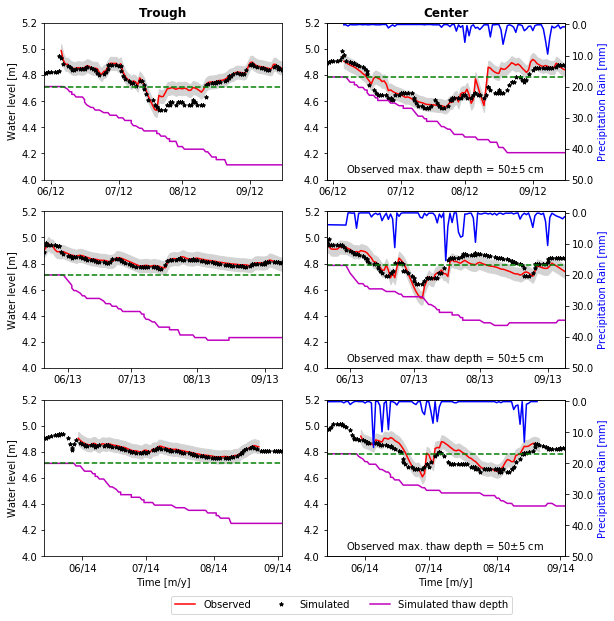

In [182]:
PlotWithCenterAverage()

In [228]:
# Compure RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
#RMSD = sqrt(mean_squared_error(testing_y, prediction))
import scipy

def get_start(sim_dat, ob_dat):
    start = 0
    for t in sim_dat:
            if t<=ob_dat:
                start = start + 1
            else:
                break
    return start
    
    
def computer_rmse_at_trough(Vars):
    #Vars = ['temperature-trough-5cm','temperature-trough-50cm','temperature-trough-150cm']
    X, Y = [], []
    Trough = []
    Count = []
    Nash_SutClif = 100
    Year = ['2012', '2013','2014']
    for i, var in enumerate(Vars):
        #L = DataObserved2012Daily[var].shape[0]
        
        d_trough = 0
        d1_trough= 0
        c_trough = 0
        denom = 0
        for j in range(3):
            
            if j == 10:
                t_0 = ObservedData2012['time_C37_yr_f'][0]
                data = ObservedData2012['water_level_C37']
            elif (j==1 or j==0):
                t_0 = ObservedData2013['time_C37_yr_f'][0]
                data = ObservedData2013['water_level_C37']
            elif (j==2):
                t_0 = ObservedData2014['time_C37_yr_f'][0]
                data = ObservedData2014['water_level_C37']
            
            start = get_start(DataSim['time_trough_f'], t_0)
            print (Year[j],var, start, DataSim['time_trough_f'][start],t_0)
            ob_mean = np.nanmean(data)
            print (start)
            for x1,x2,y in zip(DataSim['water_level_trough'][start:],DataSim['water_level_trough'][start+1:],data):
                x = (x1 + x2)/2.
    
                if not np.isnan(y):
                    d_trough = d_trough  + (x-y)**2
                    d1_trough = d1_trough + (x-y)
                    denom = denom + (y-ob_mean)**2
                    X.append(x)
                    Y.append(y)
                    
                    c_trough = c_trough + 1.
        Nash_SutClif = round(1- d_trough/denom,2)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X,Y)
        #print (np.sqrt(d_trough/c_trough), d1_trough/c_trough,r_value**2, c_trough)
        print ('RMSE=', round(np.sqrt(d_trough/c_trough),2), "Bias=", d1_trough/c_trough, "R2=", r_value**2, "Nash-Sut:",
               Nash_SutClif, c_trough)
        
        print ('-------------------')
    
def computer_rmse_at_center():
    #Vars = ['temperature-trough-5cm','temperature-trough-50cm','temperature-trough-150cm']
    X, Y = [], []
    Trough = []
    Count = []
    Nash_SutClif = 100
    Year = ['2012', '2013','2014']
    
        
    d_trough = 0
    d1_trough= 0
    c_trough = 0
    denom = 0
    for j in range(3):

        if j == 0:
            t_0 = ObservedData2012['time_C40_yr_f'][0]
            data = ObservedData2012['water_level_Center_offset']
        elif (j==1):
            t_0 = ObservedData2013['time_C39_yr_f'][0]
            data = ObservedData2013['water_level_Center']
        elif (j==2):
            t_0 = ObservedData2014['time_C39_yr_f'][0]
            data = ObservedData2014['water_level_Center']

        start = get_start(DataSim['time_trough_f'], t_0)
        print (Year[j], start, DataSim['time_center_f'][start],t_0)
        ob_mean = np.nanmean(data)
        print (start)
        for x1,x2,y in zip(DataSim['water_level_center'][start:],DataSim['water_level_center'][start+1:],data):
            x = (x1 + x2)/2.

            if not np.isnan(y):
                d_trough = d_trough  + (x-y)**2
                #print (d_trough)
                d1_trough = d1_trough + (x-y)
                denom = denom + (y-ob_mean)**2
                X.append(x)
                Y.append(y)

                c_trough = c_trough + 1.
    Nash_SutClif = round(1- d_trough/denom,2)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X,Y)
    #print (np.sqrt(d_trough/c_trough), d1_trough/c_trough,r_value**2, c_trough)
    print ('RMSE=', round(np.sqrt(d_trough/c_trough),2), "Bias=", d1_trough/c_trough, "R2=", r_value**2, "Nash-Sut:",
           Nash_SutClif, c_trough)

    print ('-------------------')




In [229]:
#computer_rmse_at_depths(Vars = ['water_level_Center'], T = ['time_C39_yr_f', ])
#print ('*****************************')
#computer_rmse_at_trough(Vars = ['water_level_C37'])
print ('*****************************')
computer_rmse_at_center()

*****************************
2012 161 2012-06-10 2012-06-09
161
2013 516 2013-06-01 2013-05-31
516
2014 898 2014-06-18 2014-06-17
898
RMSE= 0.07 Bias= -0.013301799193153102 R2= 0.6320189782045175 Nash-Sut: 0.56 304.0
-------------------
